## Libraries

In [1]:
import os

In [2]:
run = 'local' #local or cloud
os.environ["APP_ENV"] = run

In [3]:
import sys
sys.path.append('..')

In [4]:
from src.grass_functions import*
from src.data.process_inputs import*
%matplotlib inline
#%load_ext autoreload
#%autoreload 2

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Parameters

In [20]:
#set project variables
Project_Area = 'cassia_minidoka'
GRASS_GIS_Projection = projection = '6449' #set to None if you want to use the DEM's original projection
res = '2m'
## Set variables analysis
data_scale = 'Name' #other options HUC12, HUC10, HUC8 OR the field name of the source data to be split <-- case sensitive
select_data = '*' #     # Value within the filter_field used for data selection
to_headwaters = False #False if only interested in local huc area
input_shp_name = pl.Path(os.getcwd()).parent/'data'/'Vectors'/Project_Area/'Model_Basin_Delineations.shp' #None or must be populated populated with a shapefile polygons if data_scale != HUCXX
buffer = 500 #untis of projection
auto_delete = False
in_tif = 'Terrain_ID_UT_NV_NED_Mosaic_2meter.tif'
dem = 'project_dem'
aligned = False
align_rast = dem #set to False if no realignment needed

In [21]:
if data_scale.find('HUC') >= 0:
    huc_level = re.findall("[0-9]+",data_scale)[0]
    if huc_level == str(len(select_data)):
        huc_digys = huc_level
    else:
        huc_digys = huc_level
        select_data = select_data[:int(huc_digys)]

In [22]:
## Paths:
parent_dir = pl.Path(os.getcwd()).parent/'data'
current_dir = pl.Path(os.getcwd())
outputs_dir =parent_dir/'Rasters'/Project_Area/'Outputs'
vector_dir = parent_dir/'Vectors'/Project_Area
raster_dir = parent_dir/'Rasters'/Project_Area
huc_path = vector_dir/'{}_aoi.geojson'.format(Project_Area)
git_data_repo = current_dir/'data_repository'
if input_shp_name:
    input_shp = vector_dir/input_shp_name
directory = outputs_dir

### Get area of interest

In [23]:
#prep work
if data_scale.find('HUC') >= 0:
    wbd = nhd_download(select_data,vector_dir)

    #read in HUC12s vector file from NHD
    local_huc4 = gpd.read_file(vector_dir/wbd, layer='WBDHU{}'.format(huc_digys))

    #reformat fields to handle disparate USGS data formats
    local_huc4 = lower_pd_cols(local_huc4.copy())
    if to_headwaters:
        ## function to get most downstream HUC12 if HUC10 or HUC8 is entered
        select_data = get_downstream_huc12(select_data,local_huc4)

        #get all upstream HUC12s
        local_huc12 = local_huc4.loc[local_huc4['huc12'] == select_data]
        upstream_list = get_upstream_extent_usgs(select_data) #selected huc12
        aoi = local_huc4.loc[local_huc4['huc12'].isin(upstream_list) == True]
    else:
        aoi = local_huc4.loc[local_huc4['huc{}'.format(huc_digys)] == select_data]
        local_huc12 = None
else:
    aoi = gpd.read_file(input_shp)
    local_huc12 = None
#save to vector for later analysis
huc_path = vector_dir/'{0}_aoi.geojson'.format(Project_Area)
#fix topological errors
aoi['geometry'] = aoi.buffer(0) 
aoi.to_crs(epsg=projection).to_file(str(huc_path),driver="GeoJSON")

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [34]:
aoi = gpd.read_file(str(huc_path),driver="GeoJSON")


Check if OGR layer <cassia_minidoka_aoi> contains polygons...
   0   8  16  25  33  41  50  58  66  75  83  91 100
Creating attribute table for layer <cassia_minidoka_aoi>...
Importing 12 features (OGR layer <cassia_minidoka_aoi>)...
   0   8  16  25  33  41  50  58  66  75  83  91 100
-----------------------------------------------------
Registering primitives...
-----------------------------------------------------
Cleaning polygons
-----------------------------------------------------
Breaking polygons...
Breaking polygons (pass 1: select break points)...
   3   6  10  13  16  20  23  26  30  33  36  40  43  46  50  53  56  60  63  66  70  73  76  80  83  86  90  93  96 100
Breaking polygons (pass 2: break at selected points)...
   3   6  10  13  16  20  23  26  30  33  36  40  43  46  50  53  56  60  63  66  70  73  76  80  83  86  90  93  96 100
-----------------------------------------------------
Removing duplicates...
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29

0

### Start new grass session

In [25]:
#set projection if none exists
if not GRASS_GIS_Projection:
    dem_vrt = raster_dir/'dem'/'dem_{}.vrt'.format(select_data)
    GRASS_GIS_Projection = projection = get_raster_epsg(dem_vrt)
## GRASSGIS Location and Mapsets
Location = Project_Area+'_'+GRASS_GIS_Projection
Mapset = 'PERMANENT'

In [26]:
raster_dir

PosixPath('/home/data/Rasters/cassia_minidoka')

In [27]:
initialize_grass_db(Location, Mapset, GRASS_GIS_Projection)
#initialize_grass_db(Location, Mapset, GRASS_GIS_Projection)

Database Location Exists
Database Mapset Exists
None
{'GISDBASE': '/home/grassdata', 'LOCATION_NAME': 'cassia_minidoka_6449', 'MAPSET': 'PERMANENT'}


Current GRASS GIS 7 environment:


#### Review existing files

In [28]:
#list all grass files
grass_maps = list_existing_grass()

Available vector maps:

Available raster maps:


In [29]:
#remove old files if needed
remove_grass_data(grass_maps,'None','raster') #update 'None' with map name or type (i.e. 'raster' or 'vector')

### Get Raster data

In [31]:
gs.run_command('r.in.gdal', input=raster_dir/in_tif, output= dem)

Importing raster map <project_dem>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


0

## Align to specific grid (optional)

In [32]:
if aligned:
    #export realigned DEM
    gs.run_command('g.region',raster = dem, align = align_rast)
    gs.run_command('r.resamp.interp',input=dem, output=dem+'_a',method='bilinear')
    dem = dem+'_a'
    gs.parse_command('r.info',map=dem, flags='g')
    gs.run_command('r.out.gdal', input= dem, output= raster_dir/f'{dem}.tif',createopt="BIGTIFF=YES,PROFILE=GeoTIFF,TFW=YES,COMPRESS=LZW",flags='f')
else:
    ##print basins in grass @ Regional scale to confirm data and extent
    gs.run_command('g.region',raster = dem, align = dem)

In [ ]:
#add project area
basins = 'aoi'
gs.run_command('v.import', input= huc_path,  output= basins)

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
d.vect complete.


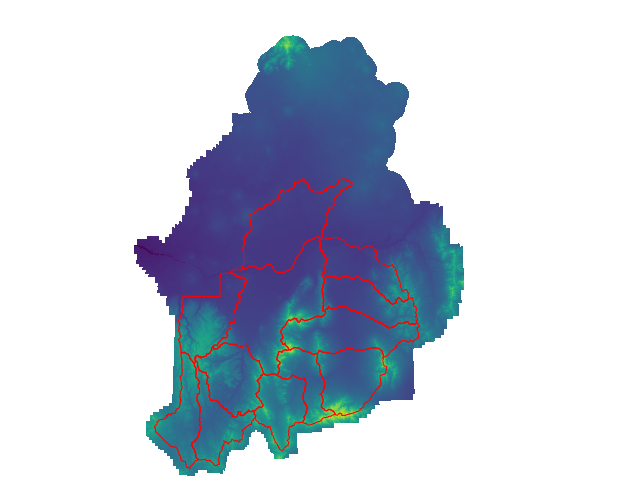

In [35]:
gs.run_command('d.erase')
gs.run_command('d.rast', map= dem)
gs.run_command('d.vect', map= 'aoi',color='red',fill_color='None')
Image(filename="map.png")

# confirm cell sizes

In [36]:
gs.parse_command('r.info',map=dem, flags='g')

{'north': '739366.3843912',
 'south': '-14851.26727547',
 'east': '2094695.83215337',
 'west': '1462853.26382004',
 'nsres': '6.5616666666667',
 'ewres': '6.56166666666663',
 'rows': '114943',
 'cols': '96293',
 'cells': '11068206299',
 'datatype': 'FCELL',
 'ncats': '0'}

In [37]:
if aligned:
    gs.parse_command('r.info',map=align_rast, flags='g')

## END